# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7"> HR Analytics: Attrition prediction

# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7"> Index
* [packages](#packages)
* [Missing values](#Missing-values)
* [Exploratory data analysis](#Exploratory-data-analysis)
* [Null values imputation](#Null-values-imputation)
* [Multivariate imputation by chained equations (MICE)](#Multivariate-imputation-by-chained-equations-(MICE))
* [Random forest and Decision Tree](#Random-forest-and-Decision-Tree)
* [Feature importances](#Feature-importances)
* [Area under the curve AUC](#Area-under-the-curve-AUC)
* [ROC Reciever Operating Characteristic](#ROC-Reciever-Operating-Characteristic)

# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Packages

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# ML classifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier

# scaling
from sklearn.preprocessing import StandardScaler

# Data imputation
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE 

# pipe
from sklearn.pipeline import Pipeline

# ML classifier model Evaluation
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.style.use('fivethirtyeight')

# plotly offline
from plotly.offline import download_plotlyjs,init_notebook_mode
init_notebook_mode(connected=True)



You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Data import

In [2]:
train = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
test = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_test.csv')

In [3]:
train.head()

enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99         Pvt Ltd           >4   
2             STEM          5          NaN             NaN        never   
3  Business Degree         <1          NaN         Pvt Ltd        never   
4             STEM        >20        50-99  Funded Startup            4   

   training_hours  target  
0              36     1.0  
1              47     0.0  
2              83     0.0  
3              52     1.0  
4               8     0.0

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
# checking for duplicates

sim = train.duplicated() 
sim.sum()

0

# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Missing values

In [6]:
# Missing value
missing_value = 100 * train.isnull().sum()/len(train)
missing_value = missing_value.reset_index()
missing_value.columns = ['variables','missing values in percentage']

#import plotly.io as pio
#pio.templates.default = "none"


# heatmap
fig = px.imshow(train.isnull().T,template='ggplot2')
fig.update_layout(title='Missing values in data set')
fig.show()

# barplot
fig = px.bar(missing_value, y='missing values in percentage',x='variables',title='Missing values % in each column',
             template='ggplot2');
fig.show()


* <span style="font-family: Arial;font-size:1.2em;color:#333333">Some of the independent variables have null value off that company type and the company size has the more than 30% of values are missing either we can do mode imputation  or we can (MICE) Multivariate imputation by chained equations
    


# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Exploratory data analysis

## <span style="font-family: Arial;font-size:1.2em;color:#333333">i. City

In [7]:
# city

plot_city = train['city'].value_counts()[0:50].reset_index()
plot_city.columns = ['City','Count']

px.bar(plot_city,x='City',y='Count',template='gridon',title='City',color='Count')

## <span style="font-family: Arial;font-size:1.2em;color:#333333">ii. City development index

<span style="font-family: Arial;font-size:1.2em;color:#333333">The CDI cuts across the different clusters identified in the Urban Indicator Framework as it is based on five sub indices namely, infrastructure, waste, health, education and city product.
It has separate sub-indices for Infrastructure, Waste Management, Health, Education, and City Product, which are averaged to form the CDI.
This formulation of the index by and large uses the same formulae as in UNDP Human Development Report (1999), for the Health, Education and City Product sub-indices.
    


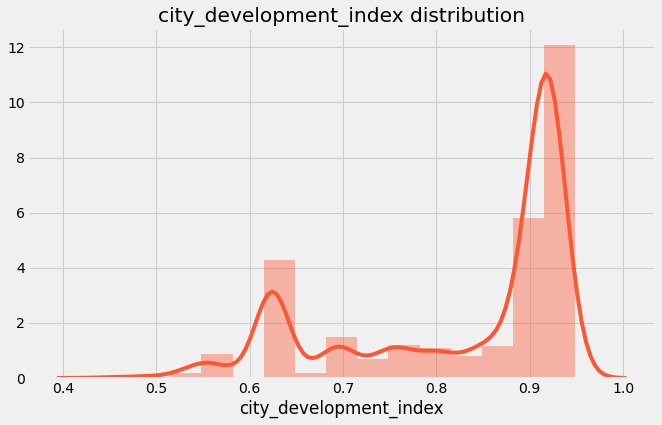

In [8]:
# CDI distribution
plt.figure(figsize=(10,6))
sns.distplot(train['city_development_index'],bins=15,color='#FF5733');
plt.title('city_development_index distribution');

In [9]:
plot_cdi =train['city_development_index'].value_counts().reset_index()[0:50] 
plot_cdi.columns = ['cdi','Count']
plot_cdi['cdi'] = plot_cdi['cdi'].astype('str')
px.bar(plot_cdi,y="Count", x="cdi",color='Count',title='City development index')


In [10]:
plot_cdi =train['city_development_index'].value_counts().reset_index()[0:50] 
plot_cdi.columns = ['cdi','Count']
px.scatter(plot_cdi,x="Count", y="cdi",color='Count',size="Count",title='City development index',template='plotly_dark')

## <span style="font-family: Arial;font-size:1.2em;color:#333333">iii. Gender

In [11]:
plot_gender = train['relevent_experience'].value_counts().reset_index()
plot_gender.columns = ['gender','count']

px.pie(plot_gender,values='count',names='gender',template='ggplot2',title='Gender')

## <span style="font-family: Arial;font-size:1.2em;color:#333333">iv. Relevent Experience

In [12]:
plot_gender = train['relevent_experience'].value_counts().reset_index()
plot_gender.columns = ['relevent_experience','count']

px.pie(plot_gender,values='count',names='relevent_experience',title='relevent_experience')
    

## <span style="font-family: Arial;font-size:1.2em;color:#333333">v. Enrolled University

In [13]:
plot_gender = train['enrolled_university'].value_counts().reset_index()
plot_gender.columns = ['enrolled_university','count']

px.pie(plot_gender,values='count',names='enrolled_university',template='simple_white',title='enrolled_university')

## <span style="font-family: Arial;font-size:1.2em;color:#333333">vi. Education level

In [14]:
plot_gender = train['education_level'].value_counts().reset_index()
plot_gender.columns = ['education_level','count']

px.pie(plot_gender,values='count',names='education_level',template='ggplot2',title='education_level')

## <span style="font-family: Arial;font-size:1.2em;color:#333333">vii. Major discipline

In [15]:
plot_gender = train['major_discipline'].value_counts().reset_index()
plot_gender.columns = ['major_discipline','count']

px.pie(plot_gender,values='count',names='major_discipline',template='plotly',title='Major discipline')

## <span style="font-family: Arial;font-size:1.2em;color:#333333">viii. Company size is determined by no. of people employees

In [16]:
plot_gender = train['company_size'].value_counts().reset_index()
plot_gender.columns = ['company_size','count']

px.pie(plot_gender,values='count',names='company_size',template='plotly_white',title='company_size is determined by no. of people employees')

# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Null values imputation

In [17]:
train_mice = train.copy()

In [18]:
# step 1 visual check for to ensure null vales are not represented with other values like -999, -1, ?,-111

for feature in train_mice.columns:
    print('*******','Column name:',feature,'*******')
    print(train_mice[feature].unique())
    print('***********-end-***********')
    print(' ')

******* Column name: enrollee_id *******
[ 8949 29725 11561 ... 24576  5756 23834]
***********-end-***********
 
******* Column name: city *******
['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_12

### <span style="font-family: Arial;font-size:1.3em;color:#3E82F7">Encode the value with map ordinal (rank order) and nominal (non-rank order)
    
#### <span style="font-family: Arial;font-size:1.3em;color:#333333"> from the data set we can observe that there are ordinal (rank order) and nominal (non-rank order) independent variables 
* <span style="font-family: Arial;font-size:1.2em;color:#333333">Some of the independent variables have the rank order like  education level, company size last new job and experience
* <span style="font-family: Arial;font-size:1.2em;color:#333333">Some of the independent variables do not have the rank order like gender, company type, relevant experience, enrolled university, major discipline, city and enrolled university
    
* <span style="font-family: Arial;font-size:1.2em;color:#333333">So with that logic, we map and encode the independent variables

In [19]:
# ******* Column name: enrolled_university *******
train_mice['enrolled_university'] = train_mice['enrolled_university'].map({'no_enrollment':int(0),'Full time course':int(1) ,'Part time course':int(-1)})

In [20]:
# ******* Column name: education_level *******
train_mice['education_level'] = train_mice['education_level'].map({'Graduate':int(0),'Masters':int(1) ,'High School':int(-1),
                                                                   'Phd':int(2),'Primary School':int(3)})

In [21]:
# ******* Column name: gender *******
train_mice['gender'] = train_mice['gender'].map({'Female':int(0),'Male':int(1) ,'Other':int(-1)})

In [22]:
# ******* Column name: experience *******

train_mice['experience'] = train_mice['experience'].map({'>20':int(20), '15':int(15),  '5':int(5), '<1':int(-1), '11':int(11), 
                                               '13':int(13), '7':int(7), '17':int(17),
                                               '2':int(7), '16':int(16), '1':int(1), '4':int(4), '10':int(10),
                                               '14':int(14), '18':int(18),'19':int(19), '12':int(12), '3':int(3), 
                                               '6':int(6), '9':int(9), '8':int(8), '20':int(20)})

In [23]:
# ******* Column name: company_size *******

train_mice['company_size'] = train_mice['company_size'].map({'50-99':int(0), '<10':int(-1), '10000+':int(1), '5000-9999':int(2), 
                                                   '1000-4999':int(3), '10/49':int(4), '100-500':int(5),'500-999':int(6)})

In [24]:
# ******* Column name: company_type *******

train_mice['company_type'] = train_mice['company_type'].map({'Pvt Ltd':int(0), 'Funded Startup':int(-1), 'Early Stage Startup':int(2), 'Other':int(3),'Public Sector':int(4), 'NGO':int(5)})

In [25]:
# ******* Column name: last_new_job *******

train_mice['last_new_job'] = train_mice['last_new_job'].map({'1':int(-1), '>4':int(0), 'never':int(1), '4':int(4), '3':int(3), '2':int(2)})

In [26]:
train_mice['major_discipline'] = train_mice['major_discipline'].map({'STEM':int(-1) ,'Business Degree':int(0), 'Arts':int(1) ,'Humanities':int(2) ,'No Major':int(3) ,'Other':int(4)})

# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Multivariate imputation by chained equations (MICE)

<span style="font-family: Arial;font-size:1.2em;color:#333333">MICE is a multiple imputation method used to replace missing data values in a data set under certain assumptions about the data missingness mechanism (e.g., the data are missing at random, the data are missing completely at random)

In [27]:
# Multivariate imputation by chained equations (MICE)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mice_imputer = IterativeImputer()

In [28]:
#  filling null values with MICE for train set

train_mice['gender'] = mice_imputer.fit_transform(train_mice[['gender']])
train_mice['gender'] = round(train_mice['gender'])

train_mice['education_level'] = mice_imputer.fit_transform(train_mice[['education_level']])
train_mice['education_level'] = round(train_mice['education_level'])

train_mice['enrolled_university']= mice_imputer.fit_transform(train_mice[['enrolled_university']])
train_mice['enrolled_university'] = round(train_mice['enrolled_university'])

train_mice['experience']= mice_imputer.fit_transform(train_mice[['experience']])
train_mice['experience'] = round(train_mice['experience'])

train_mice['company_size']= mice_imputer.fit_transform(train_mice[['company_size']])
train_mice['company_size'] = round(train_mice['company_size'])

train_mice['company_type']= mice_imputer.fit_transform(train_mice[['company_type']])
train_mice['company_type'] = round(train_mice['company_type'])

train_mice['last_new_job']= mice_imputer.fit_transform(train_mice[['last_new_job']])
train_mice['last_new_job'] = round(train_mice['last_new_job'])

train_mice['major_discipline']= mice_imputer.fit_transform(train_mice[['major_discipline']])
train_mice['major_discipline'] = round(train_mice['major_discipline'])

In [29]:
# these two independent variable does have any null values so just converting to categorical

train_mice['city'] = pd.Categorical(train_mice['city']).codes
train_mice['relevent_experience'] = pd.Categorical(train_mice['relevent_experience']).codes


In [30]:
# null values check

train_mice.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Null values imputation for test data


In [31]:
# imputation  for test set

test['enrolled_university'] = test['enrolled_university'].map({'no_enrollment':int(0),'Full time course':int(1) ,'Part time course':int(-1)})
# ******* Column name: gender *******
test['gender'] = test['gender'].map({'Female':int(0),'Male':int(1) ,'Other':int(-1)})
# ******* Column name: experience *******

test['experience'] = test['experience'].map({'>20':int(20), '15':int(15),  '5':int(5), '<1':int(-1), '11':int(11), 
                                               '13':int(13), '7':int(7), '17':int(17),
                                               '2':int(7), '16':int(16), '1':int(1), '4':int(4), '10':int(10),
                                               '14':int(14), '18':int(18),'19':int(19), '12':int(12), '3':int(3), 
                                               '6':int(6), '9':int(9), '8':int(8), '20':int(20)})
# ******* Column name: company_size *******

test['company_size'] = test['company_size'].map({'50-99':int(0), '<10':int(-1), '10000+':int(1), '5000-9999':int(2), 
                                                   '1000-4999':int(3), '10/49':int(4), '100-500':int(5),'500-999':int(6)})
# ******* Column name: company_type *******

test['company_type'] = test['company_type'].map({'Pvt Ltd':int(0), 'Funded Startup':int(-1), 'Early Stage Startup':int(2), 'Other':int(3),'Public Sector':int(4), 'NGO':int(5)})

# ******* Column name: last_new_job *******

test['last_new_job'] = test['last_new_job'].map({'1':int(-1), '>4':int(0), 'never':int(1), '4':int(4), '3':int(3), '2':int(2)})

test['major_discipline'] = test['major_discipline'].map({'STEM':int(-1) ,'Business Degree':int(0), 'Arts':int(1) ,'Humanities':int(2) ,'No Major':int(3) ,'Other':int(4)})

# ******* Column name: education_level *******
test['education_level'] = test['education_level'].map({'Graduate':int(0),'Masters':int(1) ,'High School':int(-1),
                                                                   'Phd':int(2),'Primary School':int(3)})

In [32]:
# these two independent variable does have any null values so just converting to categorical

test['city'] = pd.Categorical(test['city']).codes
test['relevent_experience'] = pd.Categorical(test['relevent_experience']).codes

In [33]:
#  filling null values with MICE for train set

test['gender'] = mice_imputer.fit_transform(test[['gender']])
test['gender'] = round(test['gender'])

test['education_level'] = mice_imputer.fit_transform(test[['education_level']])
test['education_level'] = round(test['education_level'])

test['enrolled_university']= mice_imputer.fit_transform(test[['enrolled_university']])
test['enrolled_university'] = round(test['enrolled_university'])

test['experience']= mice_imputer.fit_transform(test[['experience']])
test['experience'] = round(test['experience'])

test['company_size']= mice_imputer.fit_transform(test[['company_size']])
test['company_size'] = round(test['company_size'])

test['company_type']= mice_imputer.fit_transform(test[['company_type']])
test['company_type'] = round(test['company_type'])

test['last_new_job']= mice_imputer.fit_transform(test[['last_new_job']])
test['last_new_job'] = round(test['last_new_job'])

test['major_discipline']= mice_imputer.fit_transform(test[['major_discipline']])
test['major_discipline'] = round(test['major_discipline'])

In [34]:
# data split

X_train = train_mice[['city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours']]


train_labels = train_mice['target']

In [35]:
X_test =test[[ 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours']]

In [36]:
# test labels loaded from file

test_labels = np.load('../input/job-change-dataset-answer/jobchange_test_target_values.npy')

# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Random forest and Decision Tree

In [37]:
rf_pipe = Pipeline(steps =[ ('std_scale',StandardScaler()), ("RF",RandomForestClassifier(random_state=0,max_depth= 10, max_features= 5,min_samples_leaf= 30, min_samples_split= 100, n_estimators= 500))])
rf_pipe.fit(X_train,train_labels)

dt_pipe = Pipeline(steps =[ ('_std_scale',StandardScaler()), ("DT",DecisionTreeClassifier(criterion='gini',max_features=10, max_depth=10, min_samples_leaf=15, min_samples_split=100,random_state=0)) ])
dt_pipe.fit(X_train,train_labels)

Pipeline(steps=[('_std_scale', StandardScaler()),
                ('DT',
                 DecisionTreeClassifier(max_depth=10, max_features=10,
                                        min_samples_leaf=15,
                                        min_samples_split=100,
                                        random_state=0))])

In [38]:
# fit random forest model
rf_pipe.fit(X_train,train_labels)

Pipeline(steps=[('std_scale', StandardScaler()),
                ('RF',
                 RandomForestClassifier(max_depth=10, max_features=5,
                                        min_samples_leaf=30,
                                        min_samples_split=100, n_estimators=500,
                                        random_state=0))])

In [39]:
# fit decision Tree model
dt_pipe.fit(X_train,train_labels)


Pipeline(steps=[('_std_scale', StandardScaler()),
                ('DT',
                 DecisionTreeClassifier(max_depth=10, max_features=10,
                                        min_samples_leaf=15,
                                        min_samples_split=100,
                                        random_state=0))])

# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Feature importances

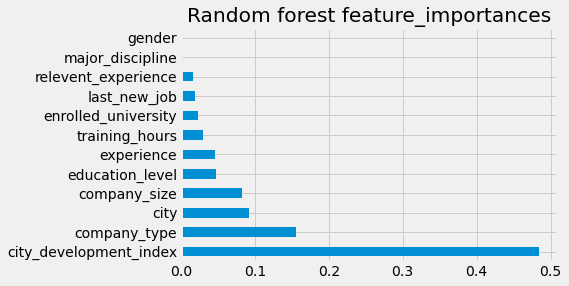

In [40]:
feature_importances = pd.Series(rf_pipe.steps[1][1].feature_importances_, index=X_train.columns);
feature_importances.nlargest(15).plot(kind='barh');
plt.title('Random forest feature_importances');

<span style="font-family: Arial;font-size:1.2em;color:#333333"> Feature importance shows us which are the independent variable are given importance and that chosen for a split of the decision trees

## <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">RF and DT model Evaluation

In [41]:
rf_train_predict = rf_pipe.predict(X_train)
rf_test_predict = rf_pipe.predict(X_test)

dt_train_predict = dt_pipe.predict(X_train)
dt_test_predict = dt_pipe.predict(X_test)

In [42]:
print('Random Forest classification_report on test_set')
print(' ')
print(classification_report(test_labels, rf_test_predict))

Random Forest classification_report on test_set
 
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85      1553
         1.0       0.61      0.41      0.49       576

    accuracy                           0.77      2129
   macro avg       0.71      0.66      0.67      2129
weighted avg       0.75      0.77      0.75      2129



In [43]:
print('Random Forest classification_report on train_set')
print(' ')
print(classification_report(train_labels, rf_train_predict))


Random Forest classification_report on train_set
 
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87     14381
         1.0       0.61      0.56      0.58      4777

    accuracy                           0.80     19158
   macro avg       0.73      0.72      0.73     19158
weighted avg       0.80      0.80      0.80     19158



In [44]:
print('Decision Tree classification_report on test_set')
print(' ')
print(classification_report(test_labels, dt_test_predict))

Decision Tree classification_report on test_set
 
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.85      1553
         1.0       0.59      0.53      0.56       576

    accuracy                           0.77      2129
   macro avg       0.71      0.70      0.70      2129
weighted avg       0.77      0.77      0.77      2129



In [45]:
print('Decision Tree classification_report on train_set')
print(' ')
print(classification_report(train_labels, dt_train_predict))

Decision Tree classification_report on train_set
 
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     14381
         1.0       0.60      0.60      0.60      4777

    accuracy                           0.80     19158
   macro avg       0.73      0.73      0.73     19158
weighted avg       0.80      0.80      0.80     19158



In [46]:
# probability for DT
rf_probs_train = rf_pipe.predict_proba(X_train)
rf_probs_train = rf_probs_train[:, 1]

rf_probs_test = rf_pipe.predict_proba(X_test)
rf_probs_test = rf_probs_test[:, 1]

# probability for DT
dt_probs_train = dt_pipe.predict_proba(X_train)
dt_probs_train = dt_probs_train[:, 1]

dt_probs_test = dt_pipe.predict_proba(X_test)
dt_probs_test = dt_probs_test[:, 1]

# <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">Area under the curve AUC
    


In [47]:
auc_RF_train = roc_auc_score(train_labels, rf_probs_train)
auc_RF_test = roc_auc_score(test_labels, rf_probs_test)

auc_dt_train = roc_auc_score(train_labels, dt_probs_train)
auc_dt_test = roc_auc_score(test_labels, dt_probs_test)

print('Random forest auc on train set',auc_RF_train)
print('Random forest auc on test set',auc_RF_test)
print(' ')
print('Decision tree auc on train set',auc_dt_train)
print('Decision tree auc on test set',auc_dt_test)

Random forest auc on train set 0.834595339310787
Random forest auc on test set 0.7930545494383631
 
Decision tree auc on train set 0.8239782819413022
Decision tree auc on test set 0.7782232641124703


> # <span style="font-family: Arial;font-size:1.2em;color:#3E82F7">ROC Reciever Operating Characteristic   
* <span style="font-family: Arial;font-size:1.2em;color:#333333">You may be wondering where the name "Reciever Operating Characteristic" came from. ROC analysis is part of a field called "Signal Dectection Theory" developed during World War II for the analysis of radar images
    
[READ This](http://gim.unmc.edu/dxtests/roc3.htm)

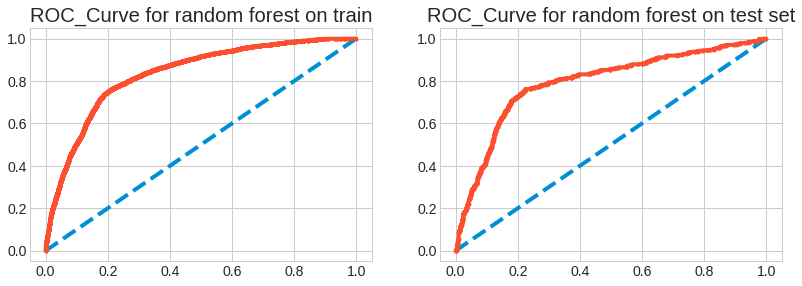

In [48]:
plt.style.use('seaborn-whitegrid')
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, rf_probs_train)
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, rf_probs_test)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))

ax1.plot([0, 1], [0, 1], linestyle='--');
ax1.plot(fpr_train, tpr_train, marker='.');
ax1.set_title('ROC_Curve for random forest on train');

ax2.plot([0, 1], [0, 1], linestyle='--');
ax2.plot(fpr_test, tpr_test, marker='.');
ax2.set_title('ROC_Curve for random forest on test set');

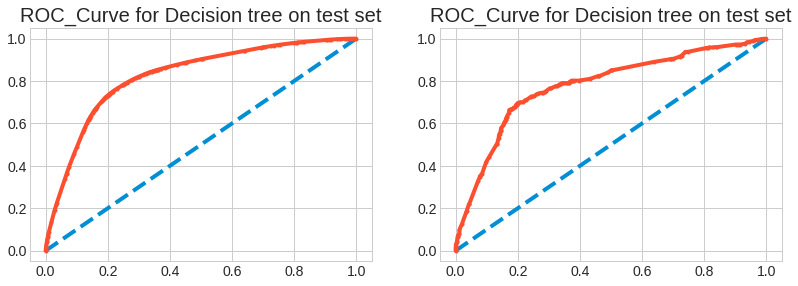

In [49]:
# plot the roc curve for the random forest model

plt.style.use('seaborn-whitegrid')


fpr_test_dt, tpr_test_dt, thresholds_test_dt = roc_curve(test_labels, dt_probs_test)
fpr_train_dt, tpr_train_dt, thresholds_train_dt = roc_curve(train_labels,dt_probs_train)


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))

ax1.plot([0, 1], [0, 1], linestyle='--');
ax1.plot(fpr_train_dt, tpr_train_dt, marker='.');
ax1.set_title('ROC_Curve for Decision tree on test set');

ax2.plot([0, 1], [0, 1], linestyle='--');
ax2.plot(fpr_test_dt, tpr_test_dt, marker='.');
ax2.set_title('ROC_Curve for Decision tree on test set');

In [50]:
predict = rf_pipe.predict_proba(X_test)
predict = predict[:, 1]

In [51]:
# Create a  DataFrame

submission = pd.DataFrame({'enrollee_id':test['enrollee_id'],'target':predict})

In [52]:
submission.head(10)

enrollee_id    target
0        32403  0.157911
1         9858  0.071899
2        31806  0.485777
3        27385  0.078230
4        27724  0.067555
5          217  0.299506
6        21465  0.552298
7        27302  0.374357
8        12994  0.229151
9        16287  0.560783

In [53]:
print('Decision tree auc on train set',auc_dt_train)
print('Decision tree auc on test data',auc_dt_train)

print(' ')
print('Random forest auc on train set',auc_RF_train)
print('Random forest auc on test data',auc_RF_test)



Decision tree auc on train set 0.8239782819413022
Decision tree auc on test data 0.8239782819413022
 
Random forest auc on train set 0.834595339310787
Random forest auc on test data 0.7930545494383631


In [54]:
submission.to_csv('submission.csv',index=False)

### Thanks!

## upvote if you like it and feel free to post any suggestions.